In [1]:
import tensorflow as tf
import sklearn.metrics
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten
import numpy as np
from os import path
import importlib
import model
from model import make_model, get_checkpoint_dir
from ModelArch import ModelArch
import json

In [80]:
importlib.reload(model)

<module 'model' from 'c:\\Users\\Mafciejewicz\\Documents\\repos\\psi-project-captcha\\model.py'>

In [26]:
gpus = tf.config.experimental.list_physical_devices('GPU')

if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)
else:
    print("No GPUs detected!")

1 Physical GPUs, 1 Logical GPUs


In [27]:
image_generator = ImageDataGenerator()

In [28]:
input_dir = "lettersDataset_final"

In [7]:
size = (50, 50)

In [30]:
train_generator = image_generator.flow_from_directory(path.join(input_dir, "train"), target_size=size, class_mode="sparse")

Found 243282 images belonging to 36 classes.


In [31]:
test_generator = image_generator.flow_from_directory(path.join(input_dir, "test"), target_size=size, class_mode="sparse", shuffle=False)

Found 60806 images belonging to 36 classes.


In [12]:
arch = ModelArch.ARCH_2

In [10]:
w,h = size
model = make_model((w, h, 3), arch)

In [13]:
checkpoint_path = path.join("checkpoints", get_checkpoint_dir(arch), "chkpt")

if not path.exists(path.dirname(checkpoint_path)):
    os.makedirs(path.dirname(checkpoint_path))

In [83]:
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,
    monitor="val_accuracy",
    mode="max",
    save_best_only=True
)

In [84]:
history = model.fit(train_generator, validation_data=test_generator, callbacks=[checkpoint_callback], epochs=10)

Epoch 1/10
7603/7603 [==============================] - 127s 17ms/step - loss: 0.6979 - accuracy: 0.8827 - val_loss: 0.4350 - val_accuracy: 0.9208
Epoch 2/10
7603/7603 [==============================] - 110s 15ms/step - loss: 0.3941 - accuracy: 0.9270 - val_loss: 0.4172 - val_accuracy: 0.9244
Epoch 3/10
7603/7603 [==============================] - 108s 14ms/step - loss: 0.3319 - accuracy: 0.9365 - val_loss: 0.4204 - val_accuracy: 0.9252
Epoch 4/10
7603/7603 [==============================] - 126s 17ms/step - loss: 0.2847 - accuracy: 0.9421 - val_loss: 0.4287 - val_accuracy: 0.9256
Epoch 5/10
7603/7603 [==============================] - 114s 15ms/step - loss: 0.2515 - accuracy: 0.9468 - val_loss: 0.4935 - val_accuracy: 0.9110
Epoch 6/10
7603/7603 [==============================] - 112s 15ms/step - loss: 0.2280 - accuracy: 0.9500 - val_loss: 0.4732 - val_accuracy: 0.9231
Epoch 7/10
7603/7603 [==============================] - 112s 15ms/step - loss: 0.2107 - accuracy: 0.9525 - val_loss: 0

In [85]:
with open(path.join(path.dirname(checkpoint_path), 'history.json'), 'w') as fp:
    json.dump(history.history, fp, indent=4)

In [86]:
model.evaluate(test_generator)

1901/1901 [==============================] - 22s 11ms/step - loss: 0.6788 - accuracy: 0.9158


[0.6787813305854797, 0.915830671787262]

In [87]:
latest = tf.train.latest_checkpoint(path.dirname(checkpoint_path))

In [88]:
model.load_weights(latest)

In [89]:
model.evaluate(test_generator)

1901/1901 [==============================] - 22s 12ms/step - loss: 0.4287 - accuracy: 0.9256


[0.4287441372871399, 0.925566554069519]

In [90]:
model.save(checkpoint_path)

INFO:tensorflow:Assets written to: checkpoints\arch3\chkpt\assets


In [91]:
testPredictions = model.predict(test_generator)

In [92]:
confusion = sklearn.metrics.confusion_matrix(np.argmax(testPredictions, axis=1), test_generator.classes)

In [93]:
import seaborn
import pandas as pd
from matplotlib import pyplot as plt

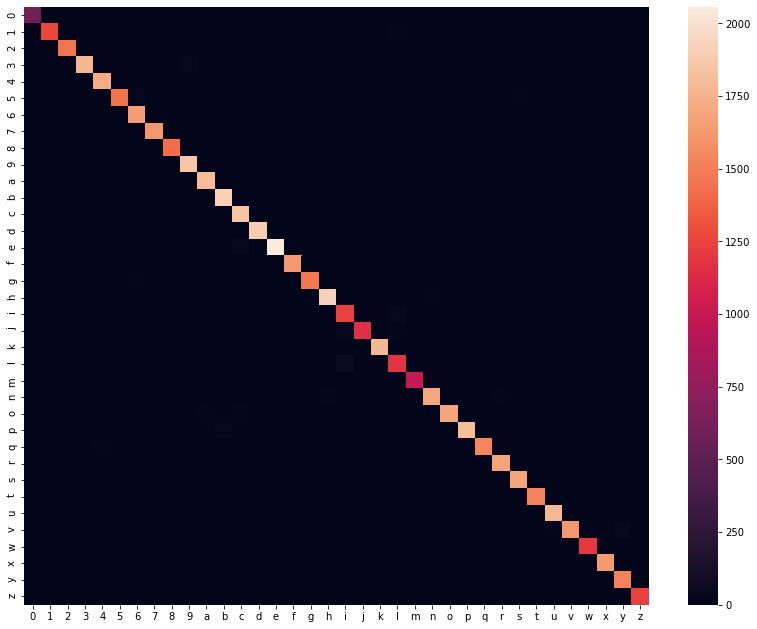

In [94]:
labels = list(test_generator.class_indices.keys())
plt.figure(figsize = (14,11))
plot = seaborn.heatmap(pd.DataFrame(confusion, index = labels, columns = labels))
figure = plot.get_figure()
figure.savefig(path.join(path.dirname(checkpoint_path), "confusion.png"))